# Import Dependencies

In [97]:
%pip install cdlib scikit-learn pandas plotly hvplot community python-louvain networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [99]:
import networkx as nx
from cdlib import algorithms, evaluation
import csv
# import sys
# import itertools
import numpy as np
# from itertools import count
# import holoviews as hv
# import hvplot.networkx as hvnx
# import plotly.graph_objects as go
import pandas as pd
# import random
import os
import seaborn as sns

from sklearn.metrics import rand_score
from sklearn.metrics import adjusted_rand_score
# from sklearn.metrics import f1_score
# from sklearn.metrics.pairwise import euclidean_distances

from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.spatial import distance
# from scipy.cluster.hierarchy import dendrogram, linkage

from networkx.algorithms import approximation
# from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.centrality import closeness_centrality

import matplotlib.pyplot as plt
# import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from sklearn.metrics import pair_confusion_matrix

# Cho Network Formation

We employ the value-based construction with a delta of 0.85.

In [100]:
delta = 0.85

Dataset = []

# open and read a tab-separated values (TSV) file, storing the first 19 columns in dataset
with open('../dataset/Cho_Ours.txt') as tsv:
    for line in csv.reader(tsv, dialect="excel-tab"):
        Dataset.append(line[:20])

# remove the header (if any) to ensure dataset contains only data
Dataset = Dataset[1:]

# calculates the number of nodes (n) based on the length of the dataset
n = len(Dataset)
print(n)

# creates an empty Networkx graph G
G = nx.Graph()

# add nodes to the graph G, each with specific attributes derived from the dataset

G.add_nodes_from([
    (
        i,  # node identifier, a unique number for each node
        {
            "label": Dataset[i][0],  # 'label' attribute, usually a name from the dataset
            "group": Dataset[i][1:3],  # 'group' attribute, a category, converted to integer
            "data": Dataset[i][3:]  # 'data' attribute, containing all remaining data points for the node

        }
    )
    for i in range(n)  # loop through each item in the dataset, where 'n' is the total number of items
])

# define edges between nodes based on specific conditions
for i in range(n):
    for j in range(i+1, n):

        #print(G.nodes[i])
        #print(G.nodes[j])

        # convert the 'data' attribute of both nodes to float for calculations
        x = [float(xi) for xi in G.nodes[i]["data"]]
        y = [float(yi) for yi in G.nodes[j]["data"]]

        # calculate distances and correlation coefficients between nodes
        d = distance.euclidean(x,y)
        m = distance.minkowski(x,y)
        pearson = np.corrcoef(x,y)[0][1]
        spearman, ps = spearmanr(x,y)
        kendall, pk = kendalltau(x,y)

        # add an edge if the Pearson correlation coefficient is above the threshold (delta)
        if pearson>=delta:
            G.add_edge(i,j, euc = d, mink= m, weight = pearson, spearman = spearman, kendall = kendall)

# ------------------------------------------------------------

Degree = dict(G.degree)
nx.set_node_attributes(G, Degree, 'degree')
print("Number of Nodes", len(G.nodes()))
print("Number of Edges", G.number_of_edges())
print("Transitivity", nx.transitivity(G))

# calculate and print the average clustering coefficient
print(approximation.average_clustering(G, trials=1000, seed=10))

# identify connected components in the graph G and print their sizes and labels
Connected_Components = [G.subgraph(c).copy() for c in nx.connected_components(G) if len(c)>1]

# used to keep track of the size of the largest connected component found so far
max = -1

# store the actual connected component that is the largest
BigC = []

# if the size (len(c)) of the current component c is greater than the current max
# update max with the new larger size
# and update BigC to be this current component.

for c in Connected_Components:
    if len(c) > max:
        max = len(c)
        BigC = c

# printing the size of the largest connected component
print("Max Component with", len(BigC))

nx.set_node_attributes(G, -1, 'gn_grp')

# ------------------------------------------------------------

# total number of nodes in the original graph before removing singletons
original_node_count = G.number_of_nodes()

# create a subgraph that contains only nodes in connected components
subG = nx.compose_all(Connected_Components)

# total number of nodes in the subgraph after removing singletons
subgraph_node_count = subG.number_of_nodes()

# calculate and print the number of singletons removed
singletons_removed = original_node_count - subgraph_node_count
print(f"Number of singletons removed: {singletons_removed}")

170
Number of Nodes 170
Number of Edges 866
Transitivity 0.6545242605274662
0.464
Max Component with 85
Number of singletons removed: 38


## Cho Network Visualization

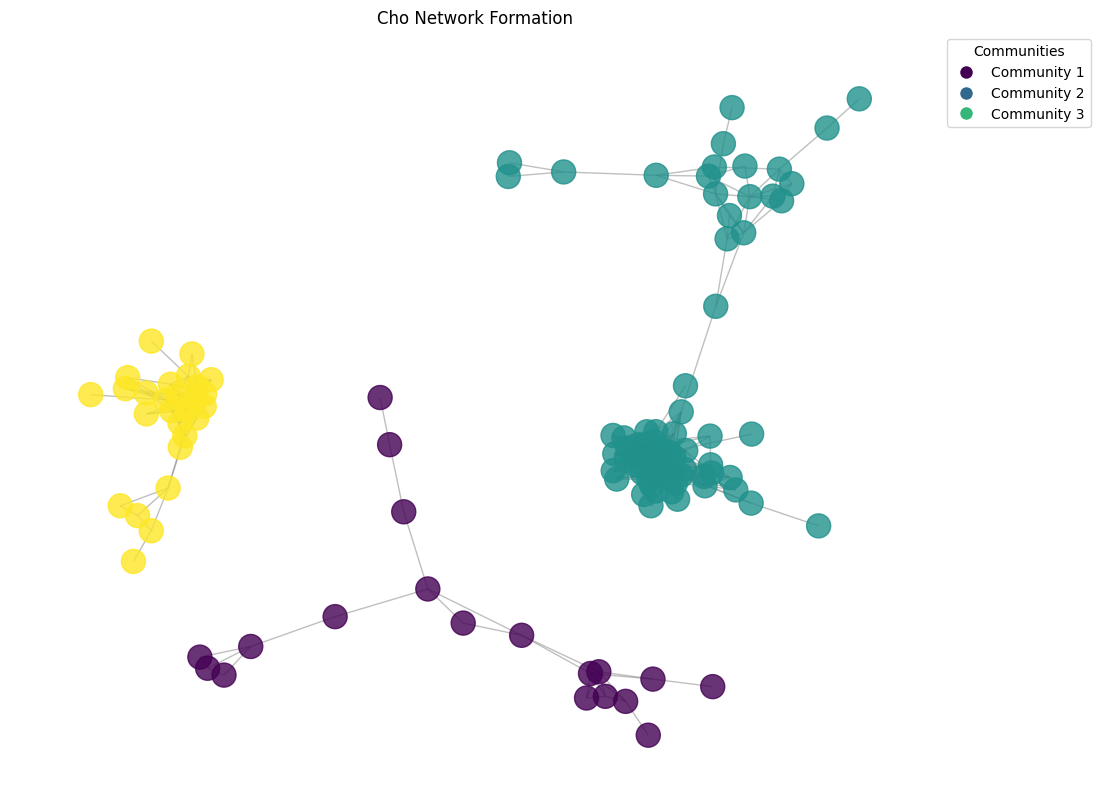

In [101]:
# create a color map, one color for each component
components = list(nx.connected_components(subG))
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = i
colors = [color_map[node] for node in subG.nodes()]

pos = nx.spring_layout(subG)

# draw the graph
plt.figure(figsize=(12, 10))
nodes = nx.draw_networkx_nodes(subG, pos, alpha=0.8, node_color=colors, cmap=plt.get_cmap('viridis'))
nx.draw_networkx_edges(subG, pos, alpha=0.5, edge_color='gray')

# create a legend
# generate a color for each component using the same colormap and normalization
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, len(components))
legend_colors = [cmap(norm(i)) for i in range(len(components))]  # Generate legend colors

# Create a legend with a color box for each component
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"Community {i+1}",
                          markerfacecolor=legend_colors[i], markersize=10) for i in range(len(components))]

plt.title('Cho Network Formation')
plt.axis('off')
plt.legend(handles=legend_elements, title='Communities', bbox_to_anchor=(1, 1))




plt.show()

# Community Detection Auxiliary Functions

These are the functions used during the Community Detection of our constructed network.

In [102]:
def visualize_community(G, communities, title, output_dir, file_name, save_file=False):
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Recalculate layout to ensure all nodes are included

    cmap = plt.get_cmap('viridis', len(communities))

    for i, community in enumerate(communities):
        if community:  # Check if community is not empty
            # Filter out nodes not present in the graph
            valid_nodes = [node for node in community if node in G]
            nx.draw_networkx_nodes(G, pos, nodelist=valid_nodes, node_color=[cmap(i)], alpha=0.8)

    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    legend_handles = [mpatches.Patch(color=cmap(i), label=f'Community {i + 1}') for i in range(len(communities))]
    plt.legend(handles=legend_handles, loc='upper left', title="Communities")
    plt.title(f"{title} Algorithm Communities")
    plt.axis('off')
    plt.tight_layout()
    if save_file:
        plt.savefig(f"{output_dir}/{file_name}.png", bbox_inches="tight")
    plt.show()

In [103]:
import itertools

def modified_rand_score(labels_true, labels_pred, nodes_true_list, nodes_pred_list):
    """
    Compute the Modified Rand Index (MRI), an extension of the Rand Index
    that accounts for missing elements between partitions.

    Parameters
    ----------
    labels_true : list
        True labels corresponding to the nodes.
    labels_pred : list
        Predicted labels corresponding to the nodes.
    nodes_true_list : list
        An ordered list of nodes corresponding to labels_true.
    nodes_pred_list : list
        An ordered list of nodes corresponding to labels_pred.

    Returns
    -------
    mri : float
        The Modified Rand Index score.
    """

    n = len(labels_true)
    total_pairs = n * (n - 1) // 2  # All possible unique node pairs
    n_00, n_11, n_xx = 0, 0, 0  # Initialize counts

    # Convert lists to sets for fast lookup
    nodes_true_set = set(nodes_true_list)
    nodes_pred_set = set(nodes_pred_list)

    # Identify common nodes between the two partitions
    common_nodes = nodes_true_set.intersection(nodes_pred_set)

    # Iterate over all node pairs
    for i, j in itertools.combinations(range(n), 2):  # Iterate over all unique pairs
        node_i, node_j = nodes_true_list[i], nodes_true_list[j]

        # If either node is missing from the common set, count this pair as n_xx.
        if node_i not in common_nodes or node_j not in common_nodes:
            n_xx += 1
        else:
            same_true = (labels_true[i] == labels_true[j])
            same_pred = (labels_pred[i] == labels_pred[j])
            if same_true and same_pred:
                n_11 += 1  # Agreeing pair (same in both)
            elif not same_true and not same_pred:
                n_00 += 1  # Agreeing pair (different in both)

    # Compute MRI Score
    if total_pairs == 0:
        return 1.0  # Perfect match in trivial cases

    MRI = (n_00 + n_11 + n_xx) / total_pairs
    return MRI


# Hierarchical Community Detection

Using our formed network, we employ the Paris and LFM Algorithms.

## Prepare Directory and Dataframe

In [104]:
output_dir = "Paris - Graphs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Paris_results = pd.DataFrame(columns=[
    "Number of Communities",
    "Nodes in Largest Community",
    "Community Sizes",
    "Singletons",
    "Modularity",
    "Closeness Centrality",
    "ARI (Level 1)",
    "ARI (Level 2)",
    "RI (Level 1)",
    "RI (Level 2)",
    "MRI (Level 1)",
    "MRI (Level 2)",
    "Communities",
    ])

## Apply Paris Algorithm and Criteria

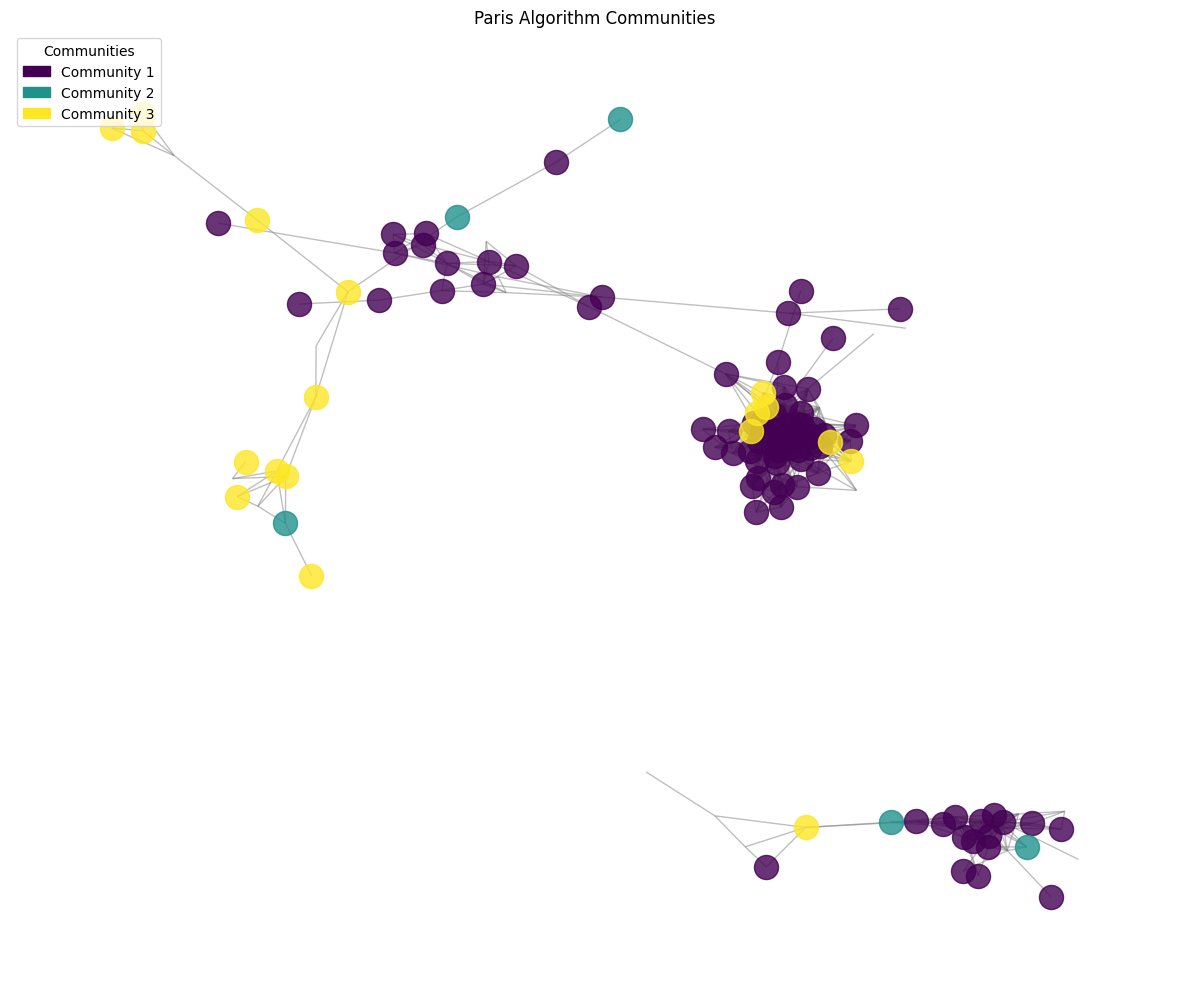

In [105]:
# Assuming subG is your graph object and it's already defined
paris_clusters = algorithms.paris(subG)

# true labels for ARI calculation
true_labels1 = [subG.nodes[n]["group"][0] for n in subG.nodes()]
true_labels2 = [subG.nodes[n]["group"][1] for n in subG.nodes()]

# prepare predicted_labels for ARI calculation
predicted_labels_dict = {node: -1 for node in subG.nodes()}
for i, community in enumerate(paris_clusters.communities):
    for node in community:
        predicted_labels_dict[node] = i
predicted_labels_list = [predicted_labels_dict[node] for node in subG.nodes()]

# ARI calculation
ari_classifications_score1 = adjusted_rand_score(true_labels1, predicted_labels_list)
ari_classifications_score2 = adjusted_rand_score(true_labels2, predicted_labels_list)

# RI calculation
ri_classifications_score1 = rand_score(true_labels1, predicted_labels_list)
ri_classifications_score2 = rand_score(true_labels2, predicted_labels_list)

# MRI calculation
nodes_true_list = list(subG.nodes())  # List of nodes in the true partition
nodes_pred_list = list(node for community in paris_clusters.communities for node in community)  # List of nodes in the predicted partition
mri_classifications_score1 = modified_rand_score(true_labels1, predicted_labels_list, nodes_true_list, nodes_pred_list)
mri_classifications_score2 = modified_rand_score(true_labels2, predicted_labels_list, nodes_true_list, nodes_pred_list)

num_communities = len(paris_clusters.communities)
community_list = [list(community) for community in paris_clusters.communities]
community_sizes = [len(community) for community in paris_clusters.communities]

# find the largest community size
largest_community_size = 0
for community in paris_clusters.communities:
    if len(community) > largest_community_size:
        largest_community_size = len(community)

num_singletons = community_sizes.count(1)

# Modularity score for Paris clusters
modularity_score = evaluation.newman_girvan_modularity(subG, paris_clusters).score

# Create subgraph using Paris clusters
subgraph = subG.subgraph([node for community in paris_clusters.communities for node in community])

# Calculate closeness centrality for all nodes in the subgraph
centrality_score = nx.closeness_centrality(subgraph)

# Calculate the overall closeness centrality score as the average of all node scores
overall_centrality_score = sum(centrality_score.values()) / len(centrality_score)

Paris_results.loc[0] = [
    num_communities, 
    largest_community_size, 
    str(community_sizes), 
    num_singletons, 
    modularity_score, 
    overall_centrality_score, 
    ari_classifications_score1, 
    ari_classifications_score2, 
    ri_classifications_score1, 
    ri_classifications_score2,
    mri_classifications_score1,
    mri_classifications_score2,
    community_list]

# visualization function call
visualize_community(subG, paris_clusters.communities, 'Paris', output_dir, 'Paris_Communities', save_file=False)

plt.close()

Paris_results.to_csv(f"{output_dir}/Paris_Results.csv")

## Paris Algorithm Results

In [106]:
Paris_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
0,3,85,"[85, 28, 19]",0,-0.477209,0.175584,0.151782,0.045553,0.594263,0.566042,0.699052,0.614041,"[[42, 81, 80, 27, 25, 52, 67, 26, 55, 51, 50, ..."


# Dynamic Community Detection
Using our formed network, we employ the Paris and LFM Algorithms.

## Prepare Directory and Dataframe

In [107]:
output_dir = "Infomap - Graphs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Infomap_results = pd.DataFrame(columns=[
    "Number of Communities",
    "Nodes in Largest Community",
    "Community Sizes",
    "Singletons",
    "Modularity",
    "Closeness Centrality",
    "ARI (Level 1)",
    "ARI (Level 2)",
    "RI (Level 1)",
    "RI (Level 2)",
    "MRI (Level 1)",
    "MRI (Level 2)",
    "Communities",
    ])

## Apply Infomap Algorithm and Criteria

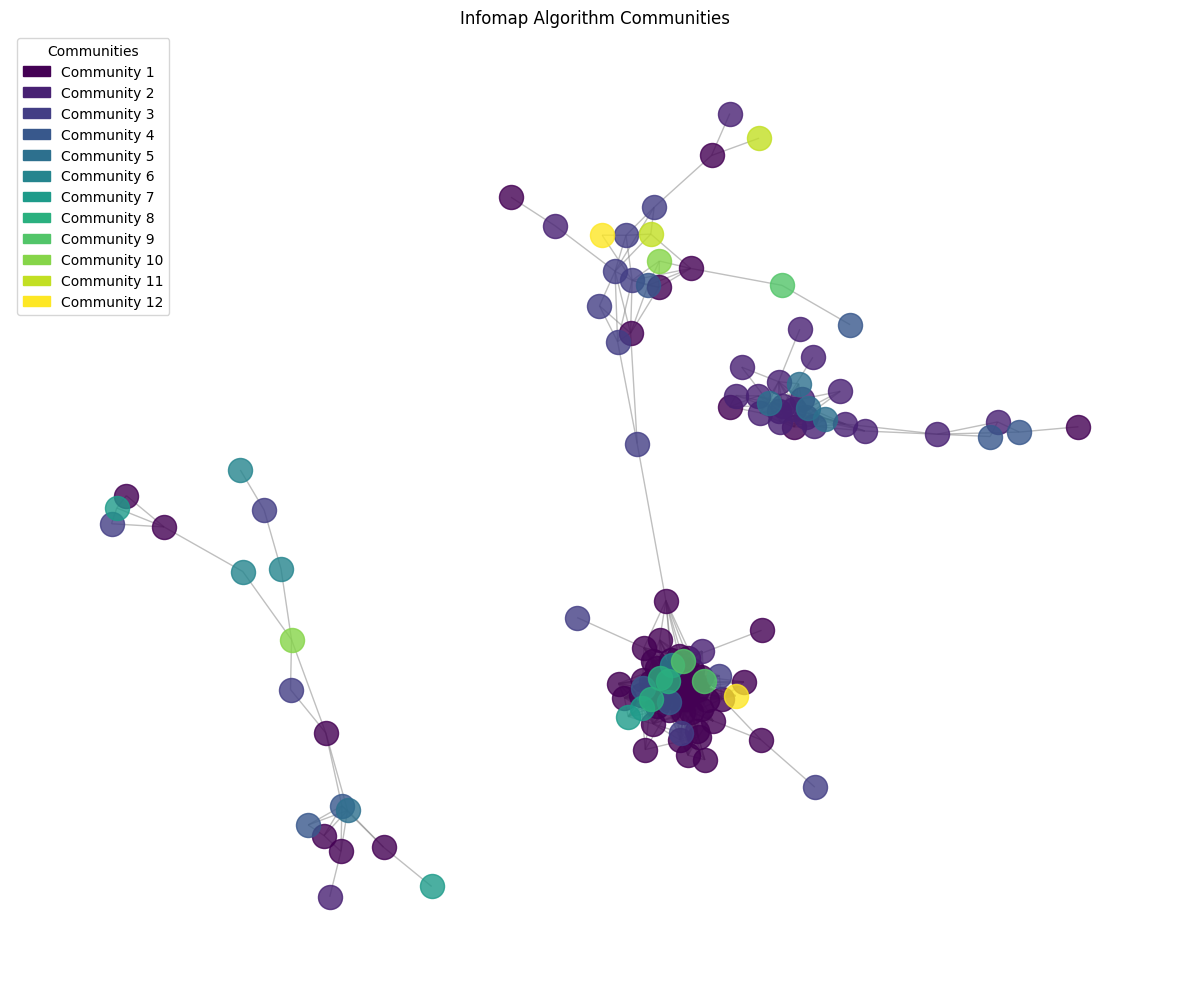

In [108]:
# Assuming subG is your graph object and it's already defined
infomap_clusters = algorithms.infomap(subG)

# true labels for ARI calculation
true_labels1 = [subG.nodes[n]["group"][0] for n in subG.nodes()]
true_labels2 = [subG.nodes[n]["group"][1] for n in subG.nodes()]

# prepare predicted_labels for ARI calculation
predicted_labels_dict = {node: -1 for node in subG.nodes()}
for i, community in enumerate(infomap_clusters.communities):
    for node in community:
        predicted_labels_dict[node] = i
predicted_labels_list = [predicted_labels_dict[node] for node in subG.nodes()]

# ARI calculation
ari_classifications_score1 = adjusted_rand_score(true_labels1, predicted_labels_list)
ari_classifications_score2 = adjusted_rand_score(true_labels2, predicted_labels_list)

# RI calculation
ri_classifications_score1 = rand_score(true_labels1, predicted_labels_list)
ri_classifications_score2 = rand_score(true_labels2, predicted_labels_list)

# MRI calculation
nodes_true_list = list(subG.nodes())  # List of nodes in the true partition
nodes_pred_list = list(node for community in infomap_clusters.communities for node in community)  # List of nodes in the predicted partition
mri_classifications_score1 = modified_rand_score(true_labels1, predicted_labels_list, nodes_true_list, nodes_pred_list)
mri_classifications_score2 = modified_rand_score(true_labels2, predicted_labels_list, nodes_true_list, nodes_pred_list)

num_communities = len(infomap_clusters.communities)
community_list = [list(community) for community in infomap_clusters.communities]
community_sizes = [len(community) for community in infomap_clusters.communities]

# find the largest community size
largest_community_size = 0
for community in infomap_clusters.communities:
    if len(community) > largest_community_size:
        largest_community_size = len(community)

num_singletons = community_sizes.count(1)

# Modularity score for Infomap clusters
modularity_score = evaluation.newman_girvan_modularity(subG, infomap_clusters).score

# Create subgraph using Infomap clusters
subgraph = subG.subgraph([node for community in infomap_clusters.communities for node in community])

# Calculate closeness centrality for all nodes in the subgraph
centrality_score = nx.closeness_centrality(subgraph)

# Calculate the overall closeness centrality score as the average of all node scores
overall_centrality_score = sum(centrality_score.values()) / len(centrality_score)

Infomap_results.loc[0] = [
    num_communities, 
    largest_community_size, 
    str(community_sizes), 
    num_singletons, 
    modularity_score, 
    overall_centrality_score, 
    ari_classifications_score1, 
    ari_classifications_score2, 
    ri_classifications_score1, 
    ri_classifications_score2,
    mri_classifications_score1,
    mri_classifications_score2,
    community_list
    ]

# visualization function call
visualize_community(subG, infomap_clusters.communities, 'Infomap', output_dir, 'Infomap_Communities', save_file=False)

plt.close()

Infomap_results.to_csv(f"{output_dir}/Infomap_Results.csv")

In [109]:
Infomap_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),RI (Level 1),RI (Level 2),MRI (Level 1),MRI (Level 2),Communities
0,12,62,"[62, 23, 14, 8, 5, 4, 4, 3, 3, 2, 2, 2]",0,0.111513,0.156545,0.430511,0.11893,0.77319,0.747051,0.77319,0.747051,"[[20, 28, 27, 26, 25, 24, 33, 32, 31, 30, 29, ..."
